In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

reducao_de_dano = {
    0:0,
    10:9,
    20:17,
    30:23.5,
    40:29,
    50:33.5,
    60:38,
    70:41.5,
    80:44.5,
    90:47.5,
    100:50.5,
    110:53,
    120:55,
    130:57,
    140:58.5,
    150:60,
    160:62,
    170:63.5,
    180:65,
    190:66,
    200:67,
}

# Realização dos testes referente a armadura e redução de defesa

* Esse é o [*Link*](https://www.kaggle.com/code/pedrohenriquecf/correla-o-armadura-e-vida-eternal-return) para saber como o teste para descobrir a quantidade de defesa que é bloqueada com base na armadura.

# Interações descobertas

* Ordem de aplicação de quebra de armadura.
1. Helix
2. Debilitation Fog
3. Armor pen %
4. Armor pen flat

* A armadura não pode ser reduzida abaixo de 0, diferente de *League of Legends*

**Exemplo: 100 de armadura**
1. Helix é aplicado (5 stacks) - 80 de armaddura
2. Debilitation fog (Bride) é aplicado, tirando 12% dos 80 e não da armadura total resultando em 70

* Todo efeito que não cause dano verdadeiro (Smolder) tem seu dano reduzido pela defesa (se beneficia da penetração de armadura do usuario)

In [2]:
# Funções

# Pegar a defesa em % referente a armadura

def calcular_media_reducao(dano, reducao_de_dano):
    chaves = sorted(reducao_de_dano.keys())

    chave_abaixo = max([chave for chave in chaves if chave <= dano], default=None)
    chave_acima = min([chave for chave in chaves if chave >= dano], default=None)

    if chave_abaixo is None or chave_acima is None:
        return None

    valor_abaixo = reducao_de_dano[chave_abaixo]
    valor_acima = reducao_de_dano[chave_acima]
    media = (valor_abaixo + valor_acima) / 2

    return media

# Diminuição da defesa

def defesa_diminuida(defesa_inicial = 0, helix=False, bride=False, flat=0, perc=0, reducao_de_dano=0):
    perc = (100 - perc) / 100
    defesa = defesa_inicial

    defesa_inicial = calcular_media_reducao(defesa_inicial, reducao_de_dano)

    if defesa_inicial is None:
        return None, None

    if helix:
        defesa -= 20

    if bride:
        defesa *= 0.88

    defesa *= perc
    defesa -= flat

    if defesa <= 0:
      defesa = 0

    defesa = calcular_media_reducao(defesa, reducao_de_dano)


    defesa_final = defesa

    return defesa_inicial, defesa_final

# Função para calcular o dano causado

def dano_causado(defesa_calculada):

  if defesa_calculada != 0:

    defesa_calculada = 100 - defesa_calculada
    defesa_calculada = defesa_calculada / 100

    dano_final = 2000 * defesa_calculada

  else:
    dano_final = 2000

  return dano_final

# Função para calcular o dano AMP
def dano_amp(armadura, amp, dscale, variantes_amp):
    variantes_amp = variantes_amp/100
    dano = 250 + (amp * variantes_amp)

    if dscale:
        armadura *= 0.85

    armadura_final = calcular_media_reducao(armadura, reducao_de_dano)
    dano_final = dano * ((100 - armadura_final) / 100)

    return dano_final



# Calculando a eficácia da penetração de armadura

Será feito o seguinte calculo:

Sera causado 2000 de dano **LIMPO** com os seguintes setups:

1. Maximo de armor pen com arma roxa: **34** (Rockers, Plasma, Shah jahan, Glacier)

2. Maximo de armor pen com build dourada: **66** (Tactical, Twilight, Chain of thorns, Iron maiden)

3. Maximo de armor pen roxa com Bloodriper: **26 + 20%** (Rockers, Plasma, *bloodripper*, Iron maiden)

4. Maximo de armor pen dourada com bloodriper: **51 + 20%** (Tactical, Twilight, *bloodripper* , Iron maiden)

5. Apenas bloodripper: **20%**, cenario em que você acha o item em uma caixa e não sabe se vale a pena usar o item ou não.

6. Sem nenhuma penetração de armadura

**O dano sera calculado de 4 maneiras diferentes**

1. Somente você atacando o alvo.

2. bride, ou seja, se o inimigo estiver sobre o efeito da nevoa de debilitação causado pelo item *Ghost bride's dress*

3. Caso o inimigo ja tenha sua armadura reduzida pelo Helix

4. Caso o inimigo esteja nas 2 condições.

*Lembrando: nesses caso algum companheiro de equipe ou (inimigo do meu inimigo) tenha aplicado as condições, você abdicar dos seus itens para fazer alguns dos citados abaixará seu dano total.*


In [3]:
# Dados de entrada
armaduras = [60, 100, 140, 180]
variantes = ['normal', 'bride', 'helix', 'ambos']
cases = {'Max pen build roxa': (34, 0), 'max pen build dourada': (66, 0), 'Max pen build roxa + bloodripper': (26, 20), 'max pen build dourada + bloodripper': (51, 20), 'Apenas o Bloodripper':(0,20), 'Sem penetração':(0,0)}

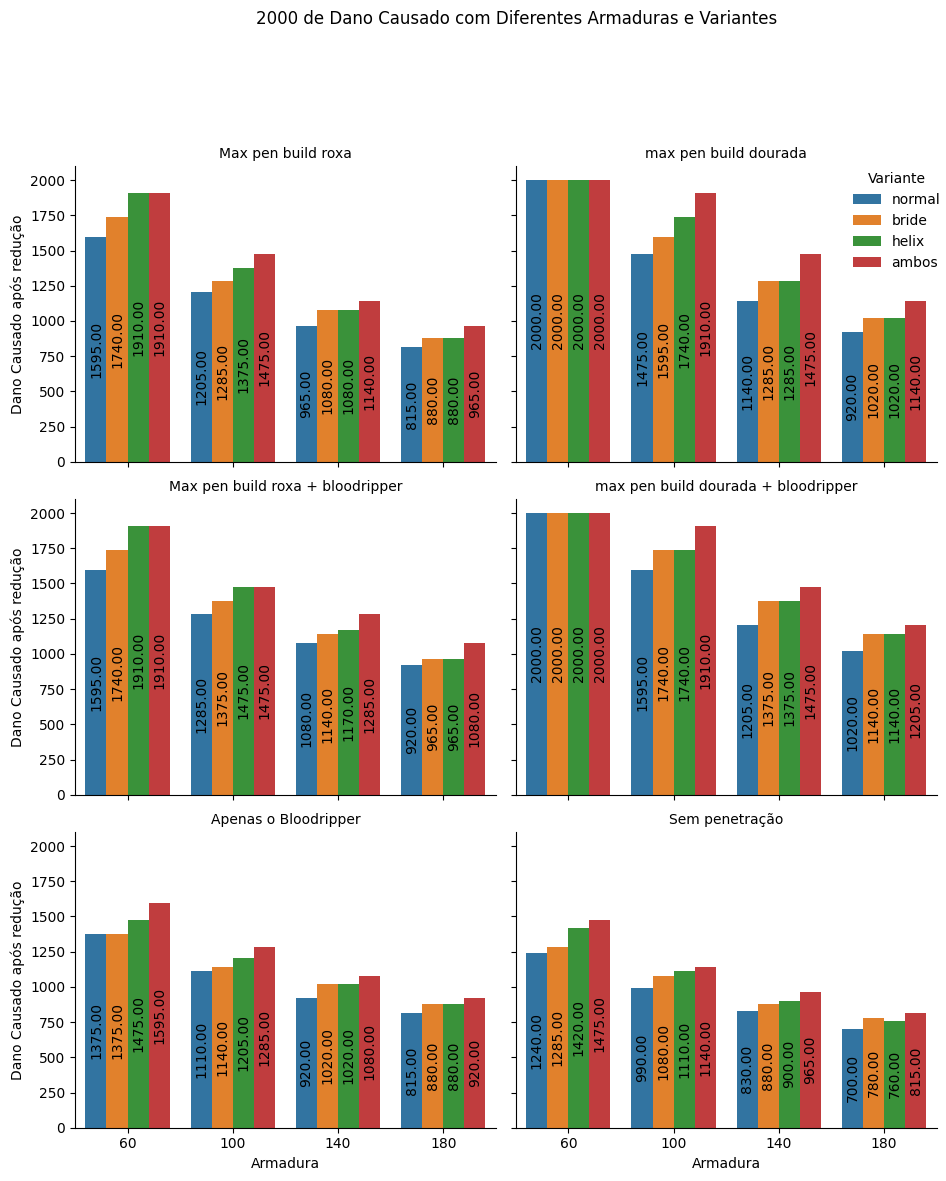

In [4]:
# DataFrame para armazenar os resultados}
data = []

for armadura in armaduras:
    for case, (flat, perc) in cases.items():
        for variante in variantes:
            helix = variante in ['helix', 'ambos']
            bride = variante in ['bride', 'ambos']

            defesa_inicial, defesa_final = defesa_diminuida(defesa_inicial=armadura, helix=helix, bride=bride, flat=flat, perc=perc, reducao_de_dano=reducao_de_dano)

            if defesa_final is not None:
                dano = dano_causado(defesa_final)
                data.append([armadura, case, variante, dano])

df = pd.DataFrame(data, columns=['Armadura', 'Caso', 'Variante', 'Dano Causado'])

# Visualização dos dados usando Seaborn Catplot
g = sns.catplot(
    x='Armadura', y='Dano Causado', hue='Variante', col='Caso',
    data=df, kind='bar', col_wrap=2, height=4, aspect=1.2
)

# Ajusta os títulos e os rótulos
g.set_titles("{col_name}")
g.set_axis_labels("Armadura", "Dano Causado após redução")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('2000 de Dano Causado com Diferentes Armaduras e Variantes')

# Adiciona os valores dentro das barras
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        # Apenas adiciona o valor se for maior que zero
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.,
                height / 2.,  # Ajuste a posição vertical para dentro da barra
                f'{height:.2f}', ha='center', va='center', color='black', rotation=90
            )

    # Define os ticks no eixo x para todos os gráficos
    ax.set_xticks([0, 1, 2, 3])  # Define a posição dos ticks
    ax.set_xticklabels([60, 100, 140, 180])  # Define os rótulos dos ticks manualmente

# Ajusta a posição e o contorno da legenda
    g._legend.set_bbox_to_anchor((0.9, 0.8))  # Ajusta a posição da legenda

plt.show()

* **Conclusão:**

1. Penetração de começo de jogo como vimos com o primeiro gráfico *(build roxa)* é bem interessante
2. Penetração roxa ou dourada é ótima contra alvos até 140 de defesa, após isso começam a fazer pouco estrago
3. Para alvos acima de 100 de armadura, a *Bloodripper* ja começa a se mostrar mais útil sendo uma boa pegar caso venha em uma caixa
4. Começar com build de penetração de armadura e trocar para Ataque puro + efeitos com base na vida como *cube watch* ou *tactical visor* é uma boa escolha.
5. Só vale a pena pegar itens de penetração de armadura no começo do jogo ou caso você queria fazer uma build inteira focada nisso.
6. Sabe aquela *Rocker's Jacket* que vc não microu o jogo todo? não vai ser ela no final da partida que vai fazer diferença.


*(Isso se aplica apenas para personagens de Poder de Ataque, se você for um personagem AMP, a duvida recorrente é "fazer persona ou dragon scale" para isso veremos)*


# Amp time: Persona ou Dragon Scale???

*Situação:* Você é um personagem com 300 de AMP e por algum motivo mistico conseguiu um Force Core no dia 2 e acabou ficando na duvida se faz **Persona** ou **Dragon Scale** logo temos 2 cenarios:

1. você com 390 de AMP *(persona)*
2. você com 300 de amp + 15% armor pen *(D.Scale)*

* *Em ambos o caso o dano base de sua habilidade sera de 250, e sera verificado com diferentes escalamentos de amp nas habilidades.*




In [5]:
# Parâmetros
armaduras_amp = [60, 100, 140, 180]
variantes_amp = [60, 70, 80, 90, 100]

<ipython-input-6-a87a8bd07835>:19: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g = sns.catplot(


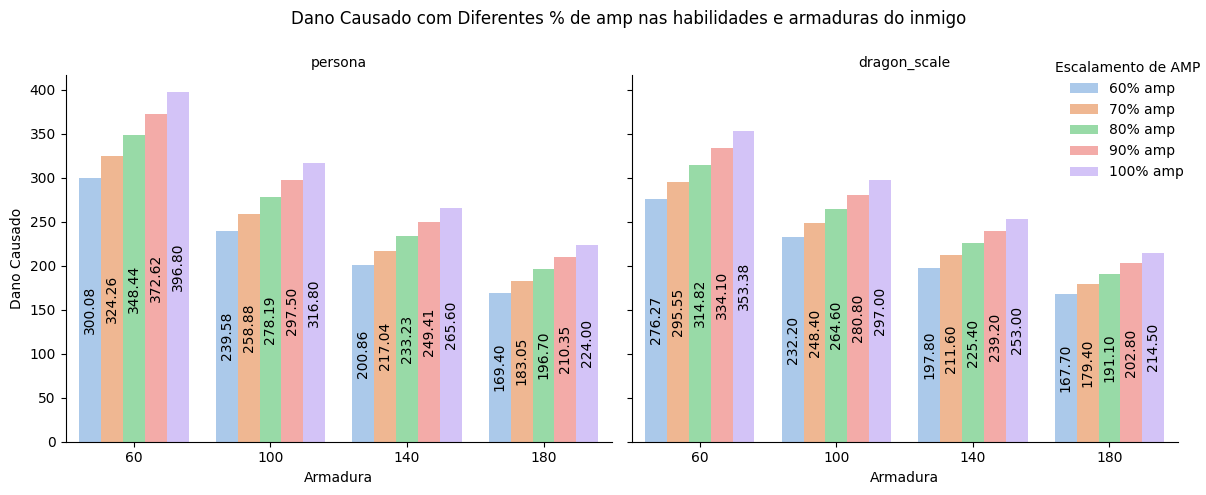

In [6]:
cases_amp = {'persona': (390, False), 'dragon_scale': (300, True)}

# Preparar dados
data = []

for armadura in armaduras_amp:
    for case, (amp, dscale) in cases_amp.items():
        for variante in variantes_amp:
            dano_final = dano_amp(armadura, amp, dscale, variante)
            data.append([armadura, case, variante, dano_final])

df = pd.DataFrame(data, columns=['Armadura', 'Caso', 'Variante', 'Dano Causado'])

# Definir cores para as variantes
# Visualização dos dados usando Seaborn Catplot

paleta = sns.color_palette("pastel")

g = sns.catplot(
    x='Armadura', y='Dano Causado', hue='Variante', col='Caso',
    data=df, kind='bar', col_wrap=2, height=5, aspect=1.2, palette=paleta
)

rotulos_variantes = {
    60: '60% amp',
    70: '70% amp',
    80: '80% amp',
    90: '90% amp',
    100: '100% amp'
}


# Ajusta os títulos e os rótulos
g.set_titles("{col_name}")
g.set_axis_labels("Armadura", "Dano Causado")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Dano Causado com Diferentes % de amp nas habilidades e armaduras do inmigo')

# Adiciona os valores dentro das barras
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        # Apenas adiciona o valor se for maior que zero
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.,
                height / 2.,  # Ajuste a posição vertical para dentro da barra
                f'{height:.2f}', ha='center', va='center', color='black', rotation=90
            )

 # Define o título da legenda
g._legend.set_title('Escalamento de AMP')
for text in g._legend.texts:
            text.set_text(rotulos_variantes.get(int(text.get_text()), text.get_text()))

g._legend.set_bbox_to_anchor((0.95, 0.75))






plt.show()

plt.show()

* **Conclusão**

1. Não tem o que falar, faz persona em todos os casos (ou o peito, tu que sabe ambos tem a mesma passiva mesmo)

*Lembrando que nesse caso, é o dano causado em* _**1 habilidade apenas**_


*Mas então Dragon Scale é ruim???*

vamos conferir no exemplo abaixo nos mesmos termos do primeiro, porém dessa vez você tem 900 de amp e vai ver a diferença com Dragon Scale e Sem Dragon Scale


<ipython-input-7-07c039553a1a>:19: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g = sns.catplot(


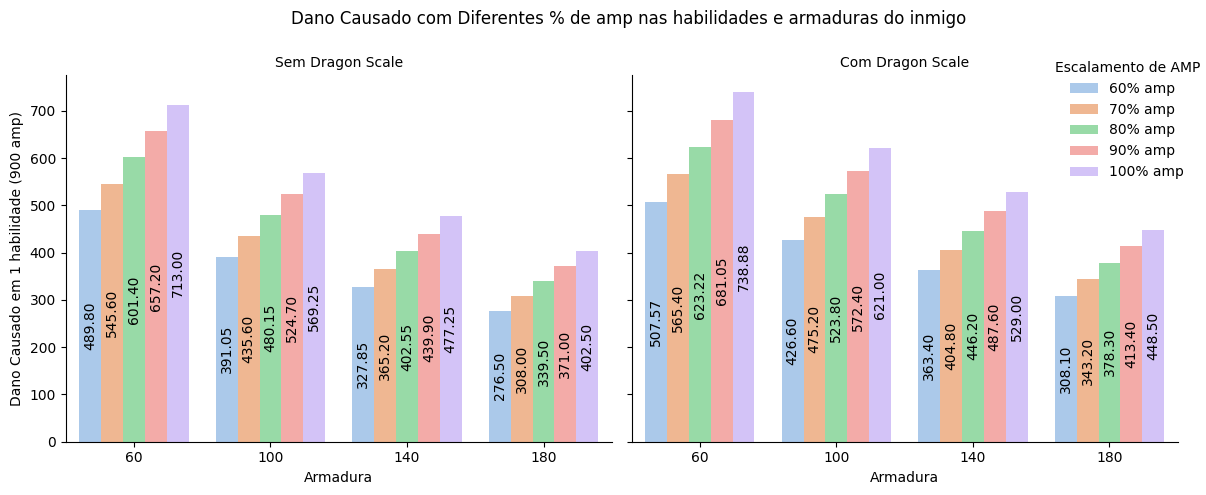

In [7]:
cases_amp = {'Sem Dragon Scale': (900, False), 'Com Dragon Scale': (900, True)}

# Preparar dados
data = []

for armadura in armaduras_amp:
    for case, (amp, dscale) in cases_amp.items():
        for variante in variantes_amp:
            dano_final = dano_amp(armadura, amp, dscale, variante)
            data.append([armadura, case, variante, dano_final])

df = pd.DataFrame(data, columns=['Armadura', 'Caso', 'Variante', 'Dano Causado'])

# Definir cores para as variantes
# Visualização dos dados usando Seaborn Catplot

paleta = sns.color_palette("pastel")

g = sns.catplot(
    x='Armadura', y='Dano Causado', hue='Variante', col='Caso',
    data=df, kind='bar', col_wrap=2, height=5, aspect=1.2, palette=paleta
)

rotulos_variantes = {
    60: '60% amp',
    70: '70% amp',
    80: '80% amp',
    90: '90% amp',
    100: '100% amp'
}


# Ajusta os títulos e os rótulos
g.set_titles("{col_name}")
g.set_axis_labels("Armadura", "Dano Causado em 1 habilidade (900 amp)")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Dano Causado com Diferentes % de amp nas habilidades e armaduras do inmigo')

# Adiciona os valores dentro das barras
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        # Apenas adiciona o valor se for maior que zero
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.,
                height / 2.,  # Ajuste a posição vertical para dentro da barra
                f'{height:.2f}', ha='center', va='center', color='black', rotation=90
            )

 # Define o título da legenda
g._legend.set_title('Escalamento de AMP')
for text in g._legend.texts:
            text.set_text(rotulos_variantes.get(int(text.get_text()), text.get_text()))

g._legend.set_bbox_to_anchor((0.95, 0.75))



plt.show()

* Conclusão

1. O dragon scale aumenta sim consideravelmente o dano para alvos acima de 100 armadura *(geralmente personagens lv 11+)*
2. Mesmo não sendo o melhor upgrade direto ainda é um ótimo upgrade aumentando o dano de 3% a 12% dependendo da armadura do alvo.

# FAQ

**Perguntas**

1. Quem sou eu?
* Prazer, meu nome é Pedro porém sou mais conhecido como *Adevo* no meio do Eternal Return

2.   Tempo de jogo?
* Não costumo jogar tanto, raramente passo de 200 partidas ranqueadas mas jogo desde a terceira temporada da Solo.

3.   Personagem favorito?
* Yuki. (Por favor Nimble volta o Yuki de Hovud eu não aguento mais)

4.   Servidor?
* South America.

5. Data realizada o teste?
* 12/09/2024 - (DD/MM/YYYY)

# Outros estudos de caso:

[*Correlação: Armadura e Vida (Eternal Return)*](https://www.kaggle.com/code/pedrohenriquecf/correla-o-armadura-e-vida-eternal-return)
